In [111]:
import numpy as np
import pandas as pd
from copy import deepcopy

In [112]:
qtd_bits = 3

In [113]:
# A tabela verdade inicia-se como uma lista vazia para receber 
# as entradas bináriasno formato array
entradas = []

# para 3 bits, precisamos gerar números de 0 à 2³ - 1 = 7 para 
# gerar a tabela verdade de 3 bits
for i in range(2 ** qtd_bits):

    i_binario_str = f"{i:0{qtd_bits}b}"
    # i_binario_str = "000" para i = 0
    # i_binario_str = "001" para i = 1
    # i_binario_str = "010" para i = 2
    # i_binario_str = "011" para i = 3
    # ...
    
    i_binario_lista = list(i_binario_str)
    # i_binario_lista = ['0', '0', '0'] para i = 0
    # i_binario_lista = ['0', '0', '1'] para i = 1
    # i_binario_lista = ['0', '1', '0'] para i = 2
    # i_binario_lista = ['0', '1', '1'] para i = 3
    # ...
    
    i_binario_arr = np.array(i_binario_lista, 
                             dtype=np.int32)
    # i_binario_arr = array([0, 0, 0]) para i = 0
    # i_binario_arr = array([0, 0, 1]) para i = 1
    # i_binario_arr = array([0, 1, 0]) para i = 2
    # i_binario_arr = array([0, 1, 1]) para i = 3
    
    # adiciona o array de bits na lista de entradas
    entradas.append(i_binario_arr)

# converter a lista de entradas em um array numpy
entradas = np.array(entradas)
entradas

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

In [114]:
saidas = []
for linha in entradas:
    # print(linha)
    # print(linha.sum())
    # print(linha.sum() % 2)

    saidas.append(linha.sum() % 2)

saidas = np.array(saidas)
saidas

array([0, 1, 1, 0, 1, 0, 0, 1])

In [115]:
# as saídas precisam ser, pelo menos, 2D para permitir 
# a predição de múltiplas saídas para cada entrada
saidas = np.atleast_2d(saidas).T
saidas

array([[0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [116]:
class BackPropagation:

    def __init__(self, entradas: np.ndarray, saidas: np.ndarray, 
                 camadas: list, lr: float, decaimento: float, seed=None) -> None:

        """
        Inicializa o objeto da rede neural com os parâmetros 
        necessários para o treinamento

        :param entradas: array 2D com as entradas da base de dados a ser ajustada
        :param saidas: array 2D com as saídas da base de dados a ser ajustada
        :param camadas: lista com a quantidade de neurônios em cada camada escondida
        :param lr: taxa de aprendizado para amortizar os gradientes
        :param decaimento: valor para decair a taxa de aprendizado a cada época
        quantidade de épocas
        """

        if len(camadas) < 1:
            raise ValueError("Precisa de pelo menos uma camada escondida para a rede neural")
        
        if entradas.shape[0] != saidas.shape[0]:
            raise ValueError("O número de linhas das entradas e saídas precisam ser iguais")
        
        if seed:
            np.random.seed(seed)

        self.entradas = entradas
        self.saidas = saidas

        camada_entrada = entradas.shape[1]
        camadas.insert(0, camada_entrada)
        camada_saida = saidas.shape[1]
        camadas.append(camada_saida)
        self.camadas = tuple(camadas)

        self.lr = lr
        self.decaimento = decaimento

        self.pesos = []
        for i in range(0, len(self.camadas) - 1):
            pesos = np.random.uniform(low=-1, high=1, 
                                      size=(self.camadas[i], self.camadas[i + 1]))
            self.pesos.append(pesos)
        
        self.historico_erros = []
    
    def __repr__(self) -> str:
        """
        Retorna a representação de uma instancia da classe BackPropagation
        """
        return f"BackPropagation(entradas={self.entradas.shape}, " \
               f"saidas={self.saidas.shape}, " \
               f"camadas={self.camadas}, " \
               f"lr={self.lr}, " \
               f"decaimento={self.decaimento})"
    
    def sigmoide(self, camada: np.ndarray) -> np.ndarray:
        """
        Calcula a função sigmoide para ativar os neurônios da rede neural

        :param camada: array 2D com os valores das camadas da rede neural
        """
        return 1 / (1 + np.exp(-camada))
    
    def derivada_sigmoide(self, sig: np.ndarray) -> np.ndarray:
        """
        Calcula a derivada da função sigmoide para ajustar os pesos 
        da rede neural

        :param sig: array 2D com as ativações da rede neural
        """
        return sig * (1 - sig)
        
    def propagacao_para_frente(self, camada_entrada: np.ndarray) -> list:
        """
        Realiza a propagação para frente para calcular as ativações 
        da rede neural

        :param camada_entrada: array 2D com as entradas da base de dados
        """

        ativacao = np.atleast_2d(camada_entrada)
        self.ativacoes = [ativacao]

        for pesos in self.pesos:
            proxima_camada = ativacao.dot(pesos)
            ativacao = self.sigmoide(proxima_camada)
            self.ativacoes.append(ativacao)
    
    def propagacao_para_tras(self, camada_saida: np.ndarray) -> tuple:
        """
        Realiza a propagação para trás para ajustar os pesos da rede neural

        :param camada_saida: array 2D com as saídas da base de dados
        """

        derivada_erro = (camada_saida - self.ativacoes[-1]) * (-1)
        derivada_sig_saida = self.derivada_sigmoide(self.ativacoes[-1])
        derivada_vermelha = derivada_erro * derivada_sig_saida

        derivadas_acumuladas = [derivada_vermelha]

        for camada in range(len(self.ativacoes) - 2, 0, -1):
            derivada_camada_sig = \
                self.derivada_sigmoide(self.ativacoes[camada])
            derivada_camada = self.pesos[camada].T
            derivada_anterior = derivadas_acumuladas[-1]

            derivada_laranja = derivada_camada * derivada_camada_sig
            derivada_acumulada = derivada_anterior.dot(derivada_laranja)
            derivadas_acumuladas.append(derivada_acumulada)

        derivadas_acumuladas = derivadas_acumuladas[::-1]

        for indice_pesos in range(0, len(self.pesos)):
            derivada_azul = self.ativacoes[indice_pesos].T
            derivada_acumulada = derivadas_acumuladas[indice_pesos]
            gradiente = derivada_azul.dot(derivada_acumulada)

            self.pesos[indice_pesos] += -self.lr * gradiente

    def predizer(self, entradas: np.ndarray) -> np.ndarray:
        """
        Prediz as saídas com base nas entradas fornecidas e os pesos 
        atuais da rede neural

        :param entradas: array 2D com as entradas a serem preditas
        """
        self.propagacao_para_frente(entradas)
        return self.ativacoes[-1]
    
    def calcula_erro_geral(self) -> float:
        """
        Calcula o erro geral da rede neural para a base de dados
        """

        saidas_preditas = self.predizer(self.entradas)

        erros = 0.50 * (saidas_preditas - self.saidas) ** 2
        erro_geral = np.mean(erros)

        return erro_geral
        
    
    def treinar(self, epocas, mostrar_resultados_a_cada):
        """
        Treina a rede neural com base nos parâmetros fornecidos

        :param epocas: quantidade de épocas para treinar a rede neural
        :param mostrar_resultados_a_cada: porcentagem de épocas para mostrar
        """
        
        if mostrar_resultados_a_cada < 0 or mostrar_resultados_a_cada > 1:
            raise ValueError("O valor de mostrar_resultados_a_cada precisa "
            "ser entre 0 e 1")
        
        mostrar_resultados_a_cada = int(mostrar_resultados_a_cada * epocas)
        
        for epoca in range(epocas):

            for iteracao in range(len(self.entradas)):

                camada_entrada = self.entradas[iteracao]
                self.propagacao_para_frente(camada_entrada=camada_entrada)

                camada_saida = self.saidas[iteracao]                
                self.propagacao_para_tras(camada_saida=camada_saida)

            ultimo_erro = self.calcula_erro_geral()
            self.historico_erros.append(ultimo_erro)

            self.lr = self.lr * (1 - self.decaimento)
            try:
                if (epoca + 1) % mostrar_resultados_a_cada == 0:
                    print(f"Epoca: {epoca + 1} ({(epoca + 1) / epocas:.0%}), " \
                          f"LR: {self.lr:.3f}, " \
                          f"Erro: {ultimo_erro:.7f}",
                          end="\r")
            except ZeroDivisionError:
                pass

In [117]:
objeto_bp = BackPropagation(entradas=entradas, 
                            saidas=saidas, 
                            camadas=[3], 
                            lr=0.1, 
                            decaimento=0.00001,
                            seed=42)

In [118]:
objeto_bp.treinar(epocas=100000, mostrar_resultados_a_cada=0.05)
objeto_bp.predizer(entradas)

array([[0.07289606],
       [0.96364861],
       [0.96262235],
       [0.01207549],
       [0.94786622],
       [0.03220946],
       [0.03279243],
       [0.99839894]])

### Rodar um modelo de classificação/regressão de dados na base de dados ``completa`` serve para demonstrar que o modelo utilizado ``é capaz`` de realizar as curvas necessárias para a topologia do problema. Porém, esta característica ``não é suficiente`` para garantir aplicabilidade do modelo em um cenário real. É necessário que o modelo seja capaz de ser treinado numa base de dados ``limitada`` (amostra), e que a partir desta amostra, seja capaz de ``generalizar`` para a base de dados completa. 


### Esta generalização pode ser obtida se os ``dados`` apresentados no treinamento possuem relação (colunas) com o objetivo do modelo. O volume de ``dados`` de treinamento precisam possuir uma quantidade de dados (linhas) razoável, ou seja, a base de treinamento (amostra) deve ser relevante em relação à população de dados.


### Não é recomendável utilizar modelos de alta complexidade para problemas de baixa complexidade, pois o modelo de alta complexidade terá que enfrentar a ``baixa probabilidade`` de encontrar (heuristicamente) os parâmetros de ajustes corretos por ter ``mais parâmetros`` do que os modelos de baixa complexidade.


### A chave para um bom trabalho de ciência de dados, é o cientista de dados ``trabalhar com os dados`` que possui até fazer uma combinação de dados com o modelo de ajuste que melhor se encaixa no problema de uma forma geral.

---
### Rodando o modelo para dados do ``MNIST`` (Digitos escritos à mão)

In [119]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets

In [120]:
# carregando os dados públicos pelo sklearn
digitos = datasets.load_digits()

In [121]:
# checando o objeto dentro da variável 'digitos'
digitos

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [122]:
print(digitos["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

In [123]:
# checando o tipo do dado 'digitos' (bunch)
type(digitos)

sklearn.utils._bunch.Bunch

In [124]:
# verificando a chave 'data' do objeto 'bunch' (tipo dicionario) 'digitos'
digitos['data'][:2]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,
         9.,  0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7.,
        15., 16., 16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,
         0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16.,
        16.,  6.,  0.,  0.,  0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

In [125]:
# carregando o array que representa as imagens
entradas = digitos['data']# .astype("float")
entradas[:2]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,
         9.,  0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7.,
        15., 16., 16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,
         0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16.,
        16.,  6.,  0.,  0.,  0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

In [126]:
# possuem 1797 imagens de 8x8 pixels. Cada pixel é um valor entre 
# 0 e 16 (int de 4 bits)
entradas.shape

(1797, 64)

In [127]:
# primeira imagem
entradas[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [128]:
# 64 atributos para cada imagem
entradas[0].shape

(64,)

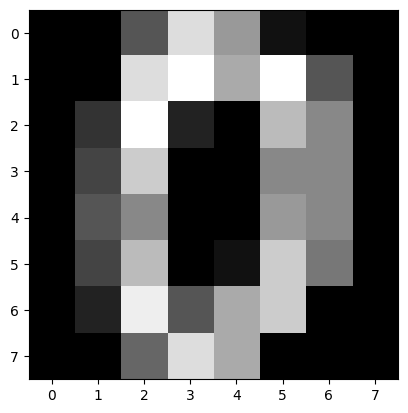

0


In [129]:
# mostrando a imagem (8x8) através do matplotlib
indice_imagem = 0

plt.imshow(entradas[indice_imagem].reshape(8, 8), cmap="gray")
plt.show()

# mostrando a classe (alvo) da imagem
print(digitos["target"][indice_imagem])

In [130]:
# observando o estado do array de saídas (alvos-target)
saidas = digitos["target"]
saidas[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [131]:
# separando as entradas e saídas em treino e teste (75% treino, 25% teste). 
# O random_state é para garantir a reprodutibilidade (seed)
trainX, testX, trainY, testY = \
    train_test_split(entradas, saidas, test_size=0.25, random_state=42)

In [132]:
# entradas de treino e teste
trainX.shape, testX.shape

((1347, 64), (450, 64))

In [133]:
# saídas de treino e teste
trainY.shape, testY.shape

((1347,), (450,))

In [134]:
# olhando o estado da variavel trainY
trainY

array([5, 2, 0, ..., 2, 7, 1])

In [135]:
# convertendo as saídas para vetores binários
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

In [136]:
# o target 0 vira [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# o target 1 vira [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
# o target 2 vira [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
# o target 3 vira [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# o target 4 vira [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
# o target 5 vira [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
# o target 6 vira [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
# o target 7 vira [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
# o target 8 vira [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
# o target 9 vira [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

# isto é o target '5'
trainY[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [137]:
# imagem pareada com o target '5' acima
trainX[0]

array([ 0.,  0.,  2., 15., 15., 16., 11.,  0.,  0.,  0.,  8., 16., 11.,
        3.,  0.,  0.,  0.,  0., 13.,  9.,  0.,  0.,  0.,  0.,  0.,  5.,
       16.,  3.,  9., 11.,  3.,  0.,  0., 10., 15., 15., 16., 16., 11.,
        0.,  0.,  6., 16., 10.,  7., 16.,  5.,  0.,  0.,  0.,  3.,  4.,
       15.,  8.,  0.,  0.,  0.,  0.,  4., 15.,  7.,  0.,  0.,  0.])

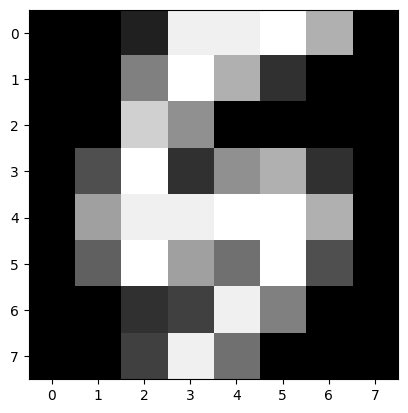

In [138]:
# mostrando a imagem (8x8) através do matplotlib
plt.imshow(trainX[0].reshape(8, 8), cmap="gray")
plt.show()

In [139]:
# isto é um '6'
testY[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [140]:
# imagem pareada com o target '6' acima
testX[0]

array([ 0.,  0.,  0.,  7., 12.,  0.,  0.,  0.,  0.,  0.,  4., 16.,  8.,
        0.,  0.,  0.,  0.,  0., 12., 11.,  0.,  0.,  0.,  0.,  0.,  0.,
       15., 10.,  8.,  6.,  1.,  0.,  0.,  0., 15., 16.,  8., 10.,  8.,
        0.,  0.,  0., 14.,  7.,  0.,  0., 12.,  0.,  0.,  0.,  8., 11.,
        0.,  5., 16.,  2.,  0.,  0.,  0.,  9., 14., 14.,  5.,  0.])

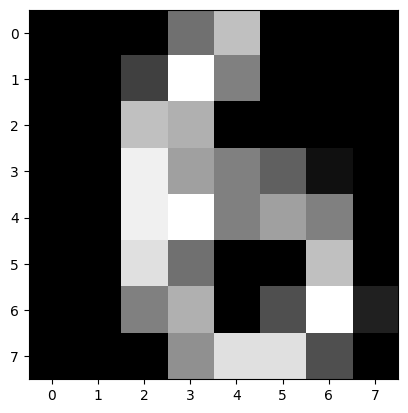

In [141]:
# mostrando a imagem (8x8) através do matplotlib
plt.imshow(testX[0].reshape(8, 8), cmap="gray")
plt.show()

### Agora, o dataset MNIST foi adaptado para ter ``64 pixels`` de entrada e ``10 classes`` de saída

In [142]:
nn = BackPropagation(
    entradas=trainX,
    saidas=trainY,
    camadas=[32, 16],
    lr=0.01,
    decaimento=0.0001,
    seed=44
)

In [143]:
# checando as camadas de entrada, escondidas e saída
nn.camadas

(64, 32, 16, 10)

In [144]:
print(nn)

BackPropagation(entradas=(1347, 64), saidas=(1347, 10), camadas=(64, 32, 16, 10), lr=0.01, decaimento=0.0001)


In [145]:
nn.treinar(epocas=100, mostrar_resultados_a_cada=0.05)

In [146]:
# predizendo a primeira saida da base de teste
nn.predizer(testX)[0]

array([3.77789760e-02, 4.96118573e-02, 2.47002854e-02, 5.01509921e-02,
       2.67922228e-02, 5.11337482e-03, 9.60185911e-01, 6.35437137e-04,
       1.25900614e-02, 1.35759801e-02])

### Acima, deve ser entendido como as 'probabilidades' de associação para cada classe. Ou seja, a classe com ``maior`` probabilidade associada é a classe que o modelo acredita ser a ``correta``.

In [147]:
# a função argmax retorna o indice do maior valor do array
np.argmax(nn.predizer(testX)[0])

6

In [148]:
# checando se a predição é igual ao alvo 'target'
np.argmax(testY[0])

6

In [149]:
# predizendo a segunda saida da base de teste
np.argmax(nn.predizer(testX)[1])

9

In [150]:
# checando se a predição é igual ao alvo 'target'
np.argmax(testY[1])

9

In [151]:
# realizando a predição em todas as lições dentro da variável 'testX' e obtendo o 
# indice do maior valor do array na dimensão (axis) 1
predicoes = nn.predizer(testX).argmax(axis=1)
predicoes

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 2, 0, 0, 1, 2, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 6, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 8, 5, 1, 4, 2,
       7, 7, 4, 4, 1, 9, 8, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 5, 5, 6, 6, 0,
       6, 4, 9, 9, 3, 8, 7, 2, 9, 0, 4, 5, 8, 6, 5, 8, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 2, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 9, 9, 1, 4, 7, 6, 5, 1, 5,
       5, 1, 0, 2, 8, 8, 9, 5, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 2, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 9, 6, 5, 9, 7, 3, 5,
       9, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 1,

In [152]:
# transformando as saidas de teste com argmax
testY.argmax(axis=1)

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 7, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 3, 5, 6, 6, 0,
       6, 4, 3, 9, 3, 9, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 8, 8, 5,
       5, 1, 6, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 9, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,

In [153]:
# comparando as predições com as saídas de teste
predicoes == testY.argmax(axis=1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [154]:
# obtendo um relatório de classificação
print(classification_report(y_true=testY.argmax(axis=1), 
                            y_pred=predicoes))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        43
           1       0.89      0.86      0.88        37
           2       0.88      0.95      0.91        38
           3       0.98      0.87      0.92        46
           4       1.00      1.00      1.00        55
           5       0.93      0.93      0.93        59
           6       0.96      0.96      0.96        45
           7       1.00      0.98      0.99        41
           8       0.81      0.89      0.85        38
           9       0.85      0.85      0.85        48

    accuracy                           0.93       450
   macro avg       0.93      0.93      0.93       450
weighted avg       0.93      0.93      0.93       450



### ``Sempre`` (1.00) que o modelo previu que era o número **7**, ele estava correto (Precision). Mas, ``nem sempre`` (0.98) que era o número 7 ele não previu corretamente (Recall).

## Matriz de Confusão
<img src="matriz_confusao.png">

---
# $ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $

### Onde:
- $TP$ = Positivos Verdadeiros (Número de positivos corretamente classificados)
- $TN$ = Positivos Negativos (Número de negativos corretamente classificados)
- $FP$ = Falsos Positivos (Número de positivos incorretamente classificados)
- $FN$ = Falsos Negativos (Número de negativos incorretamente classificados)

### Percentual de verdadeiros positivos e negativos em relação ao total de amostras.

---
# $precision = \frac{TP}{TP+FP}$

### Onde:
- $TP$ = Positivos Verdadeiros (Número de positivos corretamente classificados)
- $FN$ = Falsos Negativos (Número de negativos incorretamente classificados)

### Percentual de positivos corretamente classificados dentro do total de positivos classificados pelo modelo.

---
# $recall = \frac{TP}{TP+FN}$

### Onde:
- $TP$ = Positivos Verdadeiros (Número de positivos corretamente classificados)
- $FP$ = Falsos Positivos (Número de negativos incorretamente classificados como positivos)

### Percentual de positivos corretamente classificados dentro do total de positivos que deveriam ter sido classificados pelo modelo.

---
# $f1\_score = 2 \times \frac{precision \times recall}{precision + recall}$

### Média harmônica entre ``precision`` e ``recall``.

---
# Suporte é número de **ocorrências** de cada classe na amostra de ``teste``

In [ ]:
# mostrando o histórico de erros da rede neural ao longo das épocas
plt.figure(figsize=(10, 3))
plt.xlabel("Épocas", rotation=0, labelpad=20, fontsize=10, 
           fontweight="regular")
plt.ylabel("Erro", rotation=0, labelpad=20, fontsize=10, 
           fontweight="regular")
plt.title(f"Histórico de Erros da Rede Neural\n{nn}", 
          fontsize=10, fontweight="bold", loc="center", pad=20)
plt.plot(nn.historico_erros, label="Erro", color="blue", linewidth=1, 
         linestyle="-")
plt.legend()
plt.grid()
plt.show()

---
## Testando o modelo com Cross-Validation

In [ ]:
# mostrando as duas linhas iniciais da base de dados
entradas[:2]

In [ ]:
# as saídas estão todas em ordem, é recomendado embaralhar
saidas[:10]

In [ ]:
# quebrando as entradas em 10 divisões para cross-validation
qtd_divisoes = 3
entradas_divididas = np.array_split(entradas, qtd_divisoes)

In [ ]:
# retorna uma lista com 10 arrays
type(entradas_divididas), len(entradas_divididas)

In [ ]:
# checando o shape do primeiro array de entradas
entradas_divididas[0].shape

In [ ]:
# checando o shape do segundo array de entradas
entradas_divididas[1].shape

In [ ]:
# checando o shape do terceiro array de entradas
entradas_divididas[2].shape

In [ ]:
# dividindo as saidas também em 3 divisões
saidas_divididas = np.array_split(saidas, qtd_divisoes)

In [ ]:
# checando o shape do primeiro array de saídas
saidas_divididas[0].shape

In [ ]:
# checando o shape do segundo array de saídas
saidas_divididas[1].shape

In [ ]:
# checando o shape do terceiro array de saídas
saidas_divididas[2].shape

In [ ]:
# cria um array com a quantidade de divisões para armazenar as acurácias
acuracias = np.zeros(shape=qtd_divisoes, dtype=np.float32)

# zip pareia as entradas e saídas divididas
for indice, (entrada, saida) in enumerate(zip(entradas_divididas, saidas_divididas)):
    print(f"Rodada {indice + 1}")

    # binariza as saídas
    saida_binarizada = LabelBinarizer().fit_transform(saida)
    
    # separa as entradas e saídas em treino e teste (75% treino, 25% teste) e embaralha os dados para não haver viés de sequência
    trainX, testX, trainY, testY = \
        train_test_split(entrada, saida_binarizada, test_size=0.25, random_state=42)

    # cria o objeto da rede neural
    nn = BackPropagation(
        entradas=trainX,
        saidas=trainY,
        camadas=[32, 16],
        lr=0.01,
        decaimento=0.0001,
        seed=42
    )

    # treina o objeto da rede neural
    nn.treinar(epocas=300, mostrar_resultados_a_cada=0.05)

    # faz a predição das entradas
    predicoes = nn.predizer(testX).argmax(axis=1)

    # calcula a acurácia das predições
    acuracia = (predicoes == testY.argmax(axis=1)).sum() / len(predicoes)

    # armazena a acurácia na lista de acurácias
    acuracias[indice] = acuracia

    print("")

In [ ]:
# mostra a acurácia média das predições
acuracias.mean()

In [ ]:
def cross_validation(entradas: np.ndarray, saidas: np.ndarray,
                        k_folds: int, epocas: int, 
                        mostrar_resultados_a_cada: float,
                        camadas: list, lr: float, 
                        decaimento: float,
                        seed: int = 42) -> list:
    """
    Realiza a validação cruzada para avaliar a acurácia média da rede neural

    :param entradas: array 2D com as entradas da base de dados
    :param saidas: array 2D com as saídas da base de dados
    :param k_folds: quantidade de divisões para a validação cruzada
    :param epocas: quantidade de épocas para treinar a rede neural
    :param mostrar_resultados_a_cada: porcentagem de épocas para mostrar
    :param camadas: lista com a quantidade de neurônios em cada camada escondida
    :param lr: taxa de aprendizado para amortizar os gradientes
    :param decaimento: valor para decair a taxa de aprendizado a cada época

    :return: acurácia média dos k-folds
    """

    # divide as entradas e saídas em k partes
    entradas_divididas = np.array_split(entradas, k_folds)
    saidas_divididas = np.array_split(saidas, k_folds)

    # inicializa um array que vai receber as acurácias de cada rodada
    acuracias = np.zeros(shape=k_folds, dtype=np.float32)
    for indice, (entrada, saida) in enumerate(zip(entradas_divididas, saidas_divididas)):
        print(f"Rodada {indice + 1}")

        # binariza as saídas 
        saida_binarizada = LabelBinarizer().fit_transform(saida)

        # separa as entradas e saídas em treino e teste (75% treino, 25% teste).
        trainX, testX, trainY, testY = \
            train_test_split(entrada, saida_binarizada, test_size=0.25, random_state=42)

        # cria o objeto da rede neural
        nn = BackPropagation(
            entradas=trainX,
            saidas=trainY,
            camadas=camadas,
            lr=lr,
            decaimento=decaimento,
            seed=seed
        )

        # treina o objeto da rede neural
        nn.treinar(epocas=epocas, 
                   mostrar_resultados_a_cada=mostrar_resultados_a_cada)

        # faz a predição das entradas
        predicoes = nn.predizer(testX).argmax(axis=1)

        # calcula a acurácia das predições
        acuracia = np.mean(predicoes == testY.argmax(axis=1))

        # armazena a acurácia na lista de acurácias
        acuracias[indice] = acuracia

        print("")
        print(f"acuracia: {acuracia}")
        print("-" * 100)
    
    return acuracias.mean()

In [ ]:
acuracia_media = cross_validation(entradas=entradas,
                                    saidas=saidas,
                                    k_folds=3,
                                    epocas=500,
                                    mostrar_resultados_a_cada=0.05,
                                    camadas=[32, 16],
                                    lr=0.01,
                                    decaimento=0.00001,
                                    seed=1)
acuracia_media

### Valos realizar o teste do modelo agora deixando as saídas com uma coluna apenas e normalizada (0-9) -> (0-1)

In [ ]:
# checando as entradas
entradas

In [ ]:
# checando as saídas
saidas

In [ ]:
# as saídas devem estar no shape 2D (n_amostras, 1)
saidas = np.atleast_2d(saidas).T
saidas

In [ ]:
def normalizacao_min_max(entradas: np.ndarray) -> np.ndarray:
    """
    Normaliza as entradas entre 0 e 1

    :param entradas: array 2D com as entradas da base de dados
    :return: array 2D com as entradas normalizadas
    """
    return (entradas - entradas.min()) / (entradas.max() - entradas.min())

In [ ]:
def desnormalizacao_min_max(entradas_normalizadas: np.ndarray, 
                            entradas: np.ndarray) -> np.ndarray:
    """
    Desnormaliza as entradas entre 0 e 1

    :param entradas_normalizadas: array 2D com as entradas normalizadas
    :param entradas: array 2D com as entradas da base de dados
    :return: array 2D com as entradas desnormalizadas
    """
    return entradas_normalizadas * (entradas.max() - entradas.min()) + entradas.min()

In [ ]:
# normalizando as saídas
saidas_normalizadas = normalizacao_min_max(saidas)
saidas_normalizadas

In [ ]:
# separando as entradas e saídas em treino e teste (75% treino, 25% teste).
trainX, testX, trainY, testY = \
    train_test_split(entradas, saidas_normalizadas, test_size=0.25, random_state=42)

In [ ]:
# criando o objeto da rede neural
nn = BackPropagation(
    entradas=trainX,
    saidas=trainY,
    camadas=[32, 16],
    lr=0.01,
    decaimento=0.0001,
    seed=42
)

In [ ]:
# treinando a rede neural
nn.treinar(epocas=1000, mostrar_resultados_a_cada=0.05)

In [ ]:
predicoes = nn.predizer(testX)
predicoes[:10]

In [ ]:
predicoes_desnormalizadas = desnormalizacao_min_max(predicoes, saidas)
predicoes_desnormalizadas[:10]

In [ ]:
predicoes_desnormalizadas_arredondadas = predicoes_desnormalizadas.round(0)
predicoes_desnormalizadas_arredondadas[:10]

In [ ]:
np.concatenate([predicoes_desnormalizadas_arredondadas[:10], 
                desnormalizacao_min_max(testY[:10], saidas)], axis=1)

In [ ]:
# calculando a acurácia da rede neural
qtd_acertos = (predicoes_desnormalizadas_arredondadas == desnormalizacao_min_max(testY, saidas)).sum()
qtd_acertos

In [ ]:
# total dados
total_dados = len(testY)
total_dados

In [ ]:
acuracia = qtd_acertos / total_dados
acuracia

### Baixando os dados de ``diabetes`` do sklearn

In [ ]:
from sklearn.datasets import load_diabetes

In [ ]:
# carregando os dados públicos pelo sklearn
diabetes = load_diabetes()
diabetes

In [ ]:
# checando a descrição do dataset
print(diabetes["DESCR"])

In [ ]:
# recebendo as entradas do dataset e checando os dados
entradas = diabetes["data"]
entradas

In [ ]:
# checando o shape das entradas
entradas.shape

In [ ]:
# checando as saídas do dataset
saidas = diabetes["target"]
saidas

In [ ]:
# normalizando as saídas
saidas_normalizadas = normalizacao_min_max(saidas)
saidas_normalizadas

In [ ]:
# mostrando o shape das saídas (tem que ser 2D)
saidas.shape

In [ ]:
# transformando as saídas em 2D
saidas_normalizadas = np.atleast_2d(saidas_normalizadas).T
saidas_normalizadas[:10]

In [ ]:
# separando as entradas e saídas em treino e teste (75% treino, 25% teste).
nn = BackPropagation(
    entradas=entradas,
    saidas=saidas_normalizadas,
    camadas=[32, 16],
    lr=2,
    decaimento=0.00001,
    seed=42
)

In [ ]:
# treinando a rede neural
nn.treinar(epocas=10000, mostrar_resultados_a_cada=0.05)

In [ ]:
# funcao para calcular o erro medio absoluto
def r_quadrado(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calcula o coeficiente de determinação (R²) para avaliar a qualidade da predição

    :param y_true: array 2D com as saídas reais da base de dados
    :param y_pred: array 2D com as saídas preditas pela rede neural
    :return: coeficiente de determinação (R²)
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

In [ ]:
# predizendo as saídas da base de teste
nn.predizer(entradas)[:10]

In [ ]:
r_quadrado(y_true=saidas_normalizadas, y_pred=nn.predizer(entradas))

In [ ]:
# concatenando as saídas esperadas com as saídas preditas
np.concatenate([saidas, desnormalizacao_min_max(nn.predizer(entradas), saidas)], axis=1)[:10]